# А/А-тестирование мобильного приложения

## Описание задания
Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

**Описание колонок**
- experimentVariant – вариант эксперимента
- version – версия приложения
- purchase – факт покупки

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

from scipy import stats

In [2]:
# Загружаем данные
df = pd.read_csv('/home/jupyter-d-pershanova-17/Statistics/hw_aa.csv', sep=';')

In [22]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [23]:
# Делим данные на 2 датафрейма в соответствии с вариантом
df_0 = df.query('experimentVariant == "0"')
df_1 = df.query('experimentVariant == "1"')

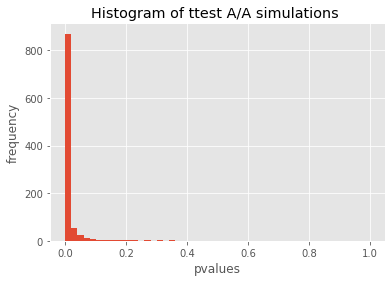

0.931

In [6]:
# А/А тест для исходных групп

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = test['cr'].sample(n_s, replace = False).values
    s2 = ['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По результатам теста видим, что pvalue < 0.05, FPR > 0.05: между группами имеется ощутимая статистическая разница.

In [7]:
# Посмотрим на среднее по покупкам для обеих групп: видим, что есть отличие больше чем в 2 раза
df.groupby('experimentVariant', as_index=False).agg({'purchase':'mean'})

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


Разобьем группы на подгруппы по версии приложения, посчитаем среднее для каждой версии и проверим количество отобранных пользователей для каждой группы по версии: в результирующей таблице видим, что соотношение количества пользователей для разных версий приложения в группах примерно соответствует, но для версии v2.8.0 есть значительное отличие в среднем числе покупок

In [8]:
df.groupby(['experimentVariant','version'], as_index=False).agg({'purchase':'mean', 'Unnamed: 0':'count'})

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Проверим количество покупок: для варианта 1 и 0 многократно отличается количество покупок для пользователей версии v2.8.0, при этом общее количество пользователей примерно равно, отсюда большое отличие в среднем по покупкам. Скорее всего в данном случае имеет место некорректное сплитование  из-за чего в группу 1 попало ощутимо больше пользователей с покупкам.

In [9]:
df.groupby(['experimentVariant','version'], as_index=False).agg({'purchase':'sum'})

,experimentVariant,version,purchase
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895
5,1,v2.9.0,858
6,1,v3.7.4.0,266
7,1,v3.8.0.0,384


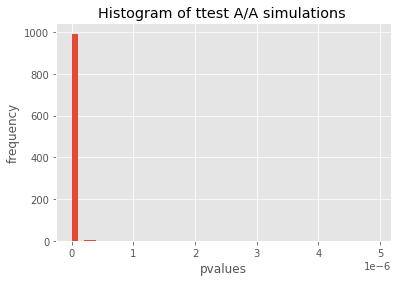

1.0

In [24]:
# Проверим pvalue для версии v2.8.0: резульат ниже подтверждает некорректность данных

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_0.query('version == "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    s2 = df_1.query('version == "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

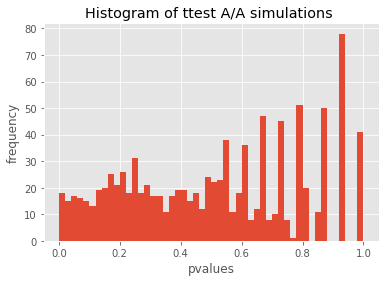

In [27]:
# Проверяем А/А тест для оставшихся версий приложения
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_0.query('version == "v2.9.0"')['purchase'].sample(n_s, replace = False).values
    s2 = df_1.query('version == "v2.9.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

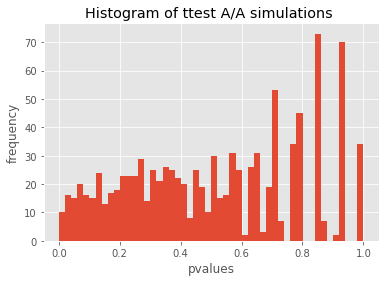

In [29]:
n = 100000
simulations = 1000
n_s = 1000
res = [] 

for i in tqdm(range(simulations)):
    s1 = df_0.query('version == "v3.7.4.0"')['purchase'].sample(n_s, replace = False).values
    s2 = df_1.query('version == "v3.7.4.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

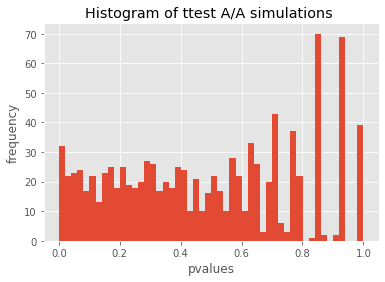

In [30]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_0.query('version == "v3.8.0.0"')['purchase'].sample(n_s, replace = False).values
    s2 = df_1.query('version == "v3.8.0.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 
    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

В остальных версиях pvalue распределно равномерно, что говорит о корректном разделении пользователей на группы
Исключаем версию v2.8.0 с pvalue < 0.05 и повторно проведем А/А тест для оставшихся версий

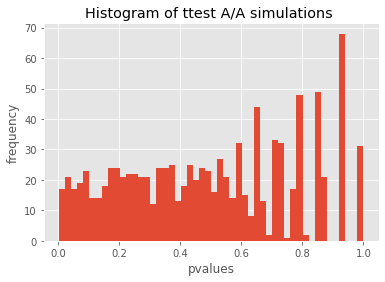

0.042

In [34]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df_0[df_0.version != 'v2.8.0']['purchase'].sample(n_s, replace = False).values
    s2 = df_1[df_1.version != 'v2.8.0']['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) 
    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) <0.05) / simulations

FPR < 0.05
**Вывод:** результат А/А тестов говорит о проблеме в сплит-системе при разделении пользователей с версией приложегния v2.8.0.